# Introduction

AI algorithms are incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, I trained train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. [This dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) concist tens or hundreds observations of  102 flower categories

The project is broken down into multiple steps:

* Loading and preprocessing the image datasets
* Training  image classifier on the datasets
* Using the trained classifier to predict image content

This project implemented in Python with PyTorch framework
The endpoint of this project is an application that can be trained on any set of labeled images and deployed.

## Importing packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
from torch import nn,optim
import torch.nn.functional as F
from torchvision import datasets,transforms,models
import time

## Loading the data

Torchvision is used to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook. The dataset is split into three parts, training, validation, and testing. 

For the training, transformations were applied such as random scaling, cropping, and flipping. This is to help the network generalize leading to better performance.
The input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. It was resized appropriately.

For all three sets, the means and standard deviations of the images were normalized. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Defining transforms for the training, validation, and testing sets

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                     transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225]),
                                     ])

test_transforms = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225]),
                                     ])

# Load the datasets with ImageFolder
trainset = datasets.ImageFolder(train_dir,transform=train_transforms)
validset =datasets.ImageFolder(valid_dir,transform=test_transforms)
testset = datasets.ImageFolder(test_dir,transform=test_transforms)

# Using the image datasets and the trainforms to define the dataloaders
trainloader = torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True)
validloader = torch.utils.data.DataLoader(validset,batch_size=64,shuffle=False)
testloader  = torch.utils.data.DataLoader(testset,batch_size=64,shuffle=False)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [5]:
print(cat_to_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

# Building and training the classifier

**Steps**

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

In [7]:
# Using GPU if it is available.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Downloading vgg16
model=models.vgg16(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:06<00:00, 84196315.61it/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [8]:
# Freezing the model.parameters

for param in model.parameters():
    param.requires_grad = False
from collections import OrderedDict

classifier = nn.Sequential(nn.Linear(25088, 4096),
                            nn.ReLU(inplace=True),
                            nn.Dropout(p=0.5),
                            nn.Linear(4096, 102),
                            nn.LogSoftmax(dim=1))
    
model.classifier = classifier

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

## Training the network

In [9]:
# Freezing the model.parameters

for param in model.parameters():
    param.requires_grad = False
from collections import OrderedDict

classifier = nn.Sequential(nn.Linear(25088, 4096),
                            nn.ReLU(inplace=True),
                            nn.Dropout(p=0.5),
                            nn.Linear(4096, 102),
                            nn.LogSoftmax(dim=1))
    
model.classifier = classifier

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

model.to(device)

# trainning the model
start=time.time()
print('begin training')

epochs = 10
train_loss = 0
steps = 0

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        
        
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        #Feedfoward
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        
        train_loss += loss.item()
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
           
    else:
        #Validation
        valid_loss = 0
        accuracy = 0
            
        #putting model in evaluation mode
        model.eval()
            
        with torch.no_grad():
            for inputs, labels in validloader:
                inputs, labels = inputs.to(device), labels.to(device)
                logps = model.forward(inputs)
                batch_loss = criterion(logps, labels)
                    
                valid_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
        print(f"Epoch {epoch+1}/{epochs}.. "
                f"Train loss: {train_loss/len(trainloader):.3f}.. "
                f"Test loss: {valid_loss/len(validloader):.3f}.. "
                f"Test accuracy: {accuracy/len(validloader):.3f}")
        train_loss = 0
        model.train()
        
time_taken = time.time() - start
print("\nTotal time: {:.0f}m {:.0f}s".format(time_taken//60, time_taken % 60))

begin training
Epoch 1/10.. Train loss: 3.335.. Test loss: 0.895.. Test accuracy: 0.763
Epoch 2/10.. Train loss: 1.463.. Test loss: 0.559.. Test accuracy: 0.854
Epoch 3/10.. Train loss: 1.299.. Test loss: 0.486.. Test accuracy: 0.863
Epoch 4/10.. Train loss: 1.244.. Test loss: 0.564.. Test accuracy: 0.856
Epoch 5/10.. Train loss: 1.151.. Test loss: 0.460.. Test accuracy: 0.884
Epoch 6/10.. Train loss: 1.137.. Test loss: 0.503.. Test accuracy: 0.862
Epoch 7/10.. Train loss: 1.117.. Test loss: 0.444.. Test accuracy: 0.887
Epoch 8/10.. Train loss: 1.076.. Test loss: 0.368.. Test accuracy: 0.898
Epoch 9/10.. Train loss: 1.052.. Test loss: 0.447.. Test accuracy: 0.895
Epoch 10/10.. Train loss: 1.032.. Test loss: 0.384.. Test accuracy: 0.898

Total time: 25m 23s


## Testing the network


In [10]:
# validation on the test set
model.eval()
test_accuracy = 0

for inputs,labels in testloader:
    inputs,labels = inputs.to(device),labels.to(device)
    
    logps = model.forward(inputs)
                        
    # Calculate accuracy
                    
    ps = torch.exp(logps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    
print(f"Test accuracy: {test_accuracy/len(testloader):.3f}")

Test accuracy: 0.872


## Saving the checkpoint

Saving the model for use and making predictions. 

In [11]:
# Save the checkpoint
model.class_to_idx =trainset.class_to_idx
checkpoint = {'arch':'vgg16','input_size': 25088, 'output_size': 102, 
              'classifier':model.classifier, 
              'mapping': model.class_to_idx, 'number_of_epochs': epochs, 'optimizer_dict': optimizer.state_dict(),
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'Checkpoint_vgg.pth')

## Loading the checkpoint

In [12]:
# Writing a function that loads a checkpoint and rebuilds the model

def load_checkpoint(file):
    checkpoint = torch.load(file)
    
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
        
    model.classifier = checkpoint['classifier']
    model.mapping = checkpoint['mapping']
    model.number_of_epochs = checkpoint['number_of_epochs']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)    
    optimizer.load_state_dict(checkpoint['optimizer_dict'])
    return optimizer, model

optimizer, model = load_checkpoint('Checkpoint_vgg.pth')

# Inference for classification

In [13]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    
    im = Image.open(image)
    size = (256, 256)
    im.thumbnail(size)
    left = (256-224)/2
    upper = (256-224)/2
    right = 224+left
    lower = 224+upper
    
    im = im.crop((left, upper, right, lower))
    im = np.array(im)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    im = (im-mean)/ std
    im = im.transpose((2,0,1)) 
    
    return im

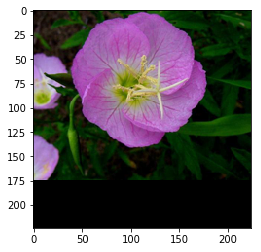

In [14]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

processed_image = process_image("flowers/test/1/image_06764.jpg")
imshow(processed_image)

## Class Prediction

In [15]:
# Defining a function for prediction

def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    model.to(device)
    model.eval()
    
    # Image needs to be preprocessed: use the process_image function defined above
    image = process_image(image_path)
   
    # Image from nd.array to tensor
    image_tensor = torch.from_numpy(image).type(torch.FloatTensor)
    model_input = image_tensor.unsqueeze(0)
    model_input = model_input.to(device)
    
    
        #Let's pass the image in our model and get the probabilities 
    output = model.forward(model_input)
    probabilities = torch.exp(output)
    
    #Top 5 probabilities and corresponding indices 
    topk_prob, topk_indices = probabilities.topk(topk)
    
    #Converting topk_prob and topk_classes to lists, so that we can loop through them without errors
    top_probabilities = topk_prob[0].tolist() 
    top_indices = topk_indices[0].tolist()
    
    #Inverted dictionary: mapping from index to class
    inverted_dic = {index:category for category, index in model.mapping.items()}
    
    
    top_numbers= [inverted_dic[element]for element in top_indices]
    top_labels= [cat_to_name[str(k)] for k in top_numbers]
     
    
    return top_probabilities, top_numbers, top_labels


#Testing the prediction function
predict("flowers/test/47/image_04966.jpg", model, topk=5)





([0.9948348999023438,
  0.005160318221896887,
  2.0199993286951212e-06,
  1.871660629149119e-06,
  4.5493475653302085e-08],
 ['47', '50', '12', '22', '5'],
 ['marigold',
  'common dandelion',
  "colt's foot",
  'pincushion flower',
  'english marigold'])

In [16]:
# Displaying an image along with the top 5 classes

def plot_solution(image_path, model):
    # Set up figure
    plt.figure(figsize = (10, 10))
    #Create frame for flower image           
    picture_frame = plt.subplot(2,1,1)
    # Display the image on the frame
    img = process_image(image_path)
    imshow(img, picture_frame);
               
    # Make prediction
    top_probabilities, top_numbers, top_labels = predict(image_path, model) 
    
    # Create second subplot
    plt.subplot(2,1,2)
    #Plot the bar chart on it          
    sns.barplot(x = top_probabilities, y = top_labels);
    #plt.barh(x = top_probabilities, y = top_labels,width=2)
    plt.show()

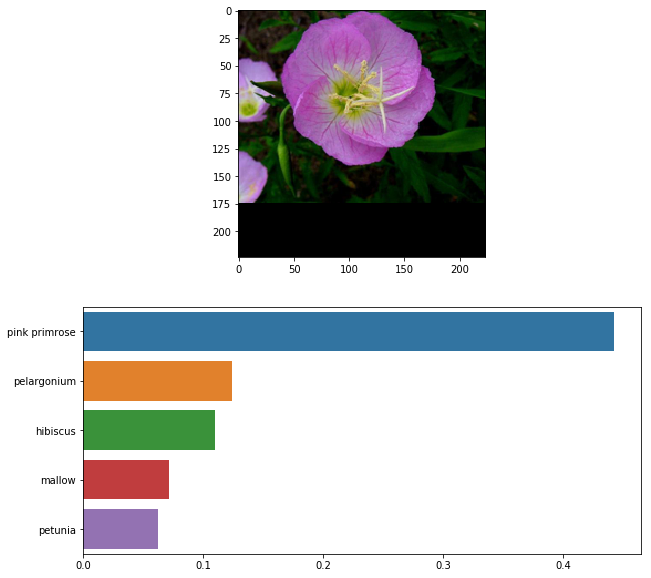

In [17]:
plot_solution("flowers/test/1/image_06764.jpg", model)

**The model correctly predicts the flower as pink primrose**